In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

from sklearn.metrics import classification_report, confusion_matrix
import itertools

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Paths to the data
data_dir = 'fish_data'  

# Basic parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# ImageDataGenerator for training with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% validation
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For the validation generator, we only rescale and do not apply augmentation.
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Train generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
valid_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Number of classes
num_classes = train_generator.num_classes
print("Number of Classes:", num_classes)

Found 8406 images belonging to 11 classes.
Found 2098 images belonging to 11 classes.
Number of Classes: 11


In [ ]:
def build_cnn_model(input_shape=(224, 224, 3), num_classes=5):
    model = Sequential()
    
    # Convolution Block 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
    
    # Convolution Block 2
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    # Convolution Block 3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Building the CNN model
cnn_model = build_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=num_classes)

# Compiling the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Model summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,379 (42.61 MB)

 Trainable params: 11,170,379 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_history = cnn_model.fit(
    train_generator,
    epochs=10,  
    validation_data=valid_generator,
    callbacks=[early_stop],
    verbose=1
)

# Evaluating on validation data
val_loss, val_acc = cnn_model.evaluate(valid_generator)
print(f"CNN Validation Accuracy: {val_acc*100:.2f}%")

# Saving the CNN model
cnn_model.save('cnn_model.h5')

Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 193s 731ms/step - accuracy: 0.2729 - loss: 2.2172 - val_accuracy: 0.5896 - val_loss: 1.2002
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 158s 600ms/step - accuracy: 0.5161 - loss: 1.3176 - val_accuracy: 0.7541 - val_loss: 0.7152
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 107s 406ms/step - accuracy: 0.6280 - loss: 1.0236 - val_accuracy: 0.8089 - val_loss: 0.5546
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 102s 386ms/step - accuracy: 0.7139 - loss: 0.8202 - val_accuracy: 0.8151 - val_loss: 0.5497
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 226s 859ms/step - accuracy: 0.7604 - loss: 0.6595 - val_accuracy: 0.8990 - val_loss: 0.3374
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 104s 394ms/step - accuracy: 0.7836 - loss: 0.6017 - val_accuracy: 0.9237 - val_loss: 0.2667
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 106s 402ms/step - accuracy: 0.8066 - loss: 0.5421 - val_accuracy: 0.9266 - val_loss: 0.2793
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 105s 401ms/step - accuracy: 0.8258 -

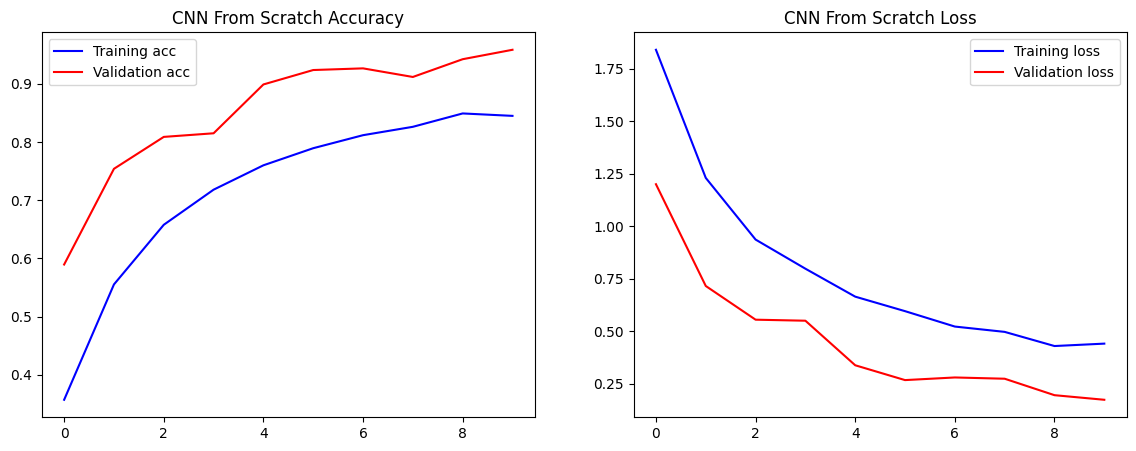

In [5]:
def plot_training_history(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    
    plt.show()

plot_training_history(cnn_history, "CNN From Scratch")

In [ ]:
def create_pretrained_model(base_model, input_shape=(224, 224, 3), num_classes=5, preprocess_func=None, fine_tune_at=None):
    """
    base_model: A Keras pre-trained model instance (without classifier layers).
    preprocess_func: Preprocessing function for the chosen architecture.
    fine_tune_at: If not None, unfreeze layers at this index.
    """
    # Freezing all layers initially
    base_model.trainable = False
    
    if fine_tune_at is not None:
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True

    # Building the final model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [7]:
def train_and_evaluate_model(model, train_gen, valid_gen, epochs=10, model_name="Model"):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=valid_gen,
        callbacks=[early_stop],
        verbose=1
    )
    
    val_loss, val_acc = model.evaluate(valid_gen, verbose=0)
    print(f"{model_name} Validation Accuracy: {val_acc*100:.2f}%")
    return model, history, val_acc

Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.1475 - loss: 2.4404 - val_accuracy: 0.4557 - val_loss: 2.0038
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.3055 - loss: 2.0230 - val_accuracy: 0.6101 - val_loss: 1.7693
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.4262 - loss: 1.7925 - val_accuracy: 0.6768 - val_loss: 1.5854
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.4867 - loss: 1.6506 - val_accuracy: 0.7097 - val_loss: 1.4358
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.5446 - loss: 1.5040 - val_accuracy: 0.7550 - val_loss: 1.3063
VGG16 Validation Accuracy: 75.50%


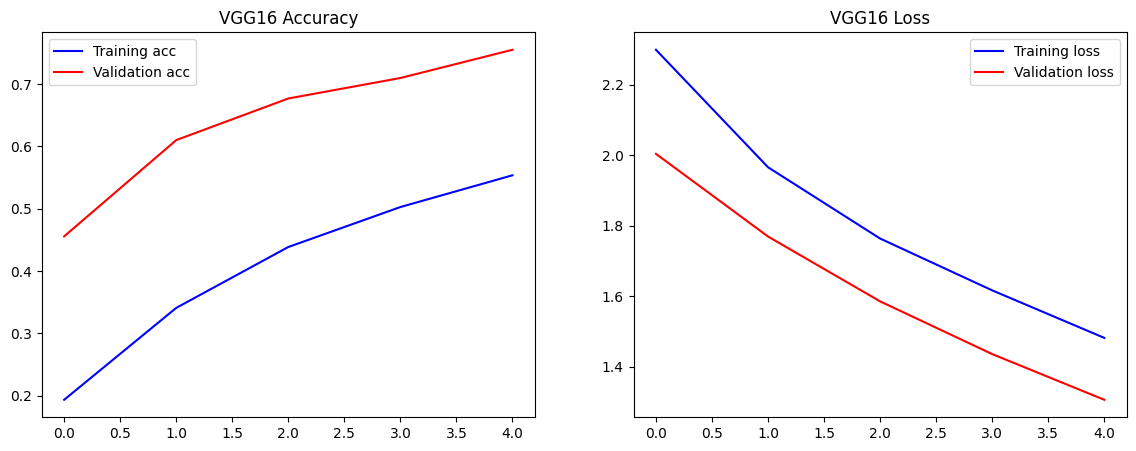

In [8]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
vgg_model = create_pretrained_model(vgg_base, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), 
                                    num_classes=num_classes, preprocess_func=vgg_preprocess)

vgg_model, vgg_history, vgg_acc = train_and_evaluate_model(vgg_model, train_generator, valid_generator, epochs=5, model_name="VGG16")
plot_training_history(vgg_history, "VGG16")

Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 174s 653ms/step - accuracy: 0.1380 - loss: 2.5165 - val_accuracy: 0.1616 - val_loss: 2.2749
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 171s 651ms/step - accuracy: 0.1722 - loss: 2.2961 - val_accuracy: 0.1773 - val_loss: 2.2430
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 172s 653ms/step - accuracy: 0.1816 - loss: 2.2618 - val_accuracy: 0.1692 - val_loss: 2.2125
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 171s 649ms/step - accuracy: 0.1826 - loss: 2.2416 - val_accuracy: 0.1902 - val_loss: 2.1929
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 171s 649ms/step - accuracy: 0.1852 - loss: 2.2287 - val_accuracy: 0.1859 - val_loss: 2.1682
ResNet50 Validation Accuracy: 18.59%


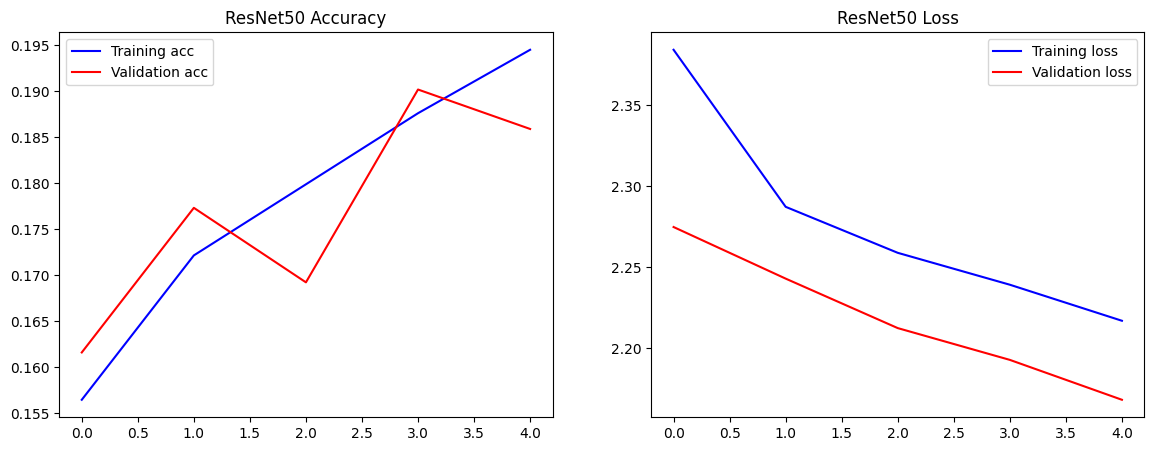

In [9]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
resnet_model = create_pretrained_model(resnet_base, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                       num_classes=num_classes, preprocess_func=resnet_preprocess)

resnet_model, resnet_history, resnet_acc = train_and_evaluate_model(resnet_model, train_generator, valid_generator, epochs=5, model_name="ResNet50")
plot_training_history(resnet_history, "ResNet50")

Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 77s 290ms/step - accuracy: 0.2852 - loss: 2.2122 - val_accuracy: 0.8642 - val_loss: 0.8119
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 77s 292ms/step - accuracy: 0.6951 - loss: 0.9702 - val_accuracy: 0.9495 - val_loss: 0.3792
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 77s 292ms/step - accuracy: 0.8221 - loss: 0.5948 - val_accuracy: 0.9685 - val_loss: 0.2285
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 77s 291ms/step - accuracy: 0.8783 - loss: 0.4112 - val_accuracy: 0.9762 - val_loss: 0.1608
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 76s 291ms/step - accuracy: 0.9054 - loss: 0.3266 - val_accuracy: 0.9814 - val_loss: 0.1229
MobileNet Validation Accuracy: 98.14%


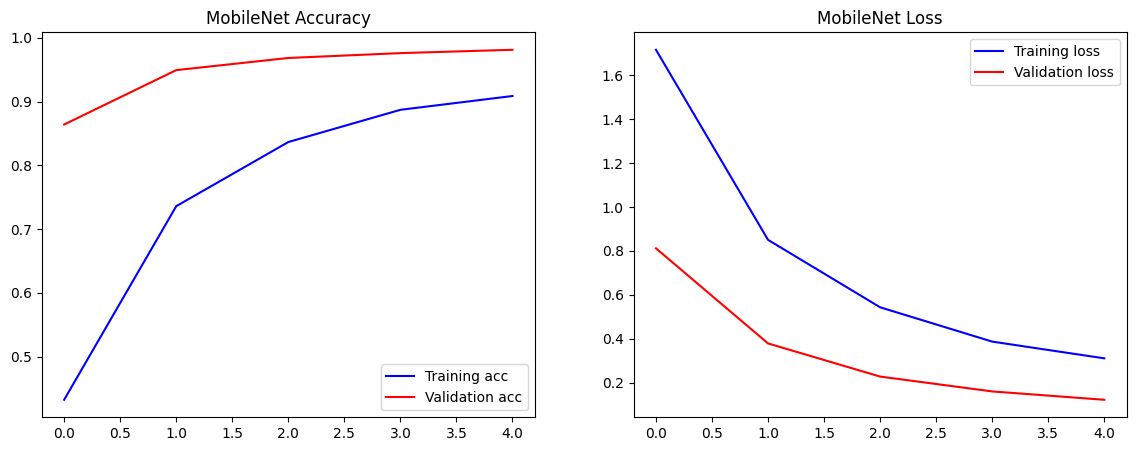

In [10]:
mobile_base = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
mobile_model = create_pretrained_model(mobile_base, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                       num_classes=num_classes, preprocess_func=mobilenet_preprocess)

mobile_model, mobile_history, mobile_acc = train_and_evaluate_model(mobile_model, train_generator, valid_generator, epochs=5, model_name="MobileNet")
plot_training_history(mobile_history, "MobileNet")

Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 104s 384ms/step - accuracy: 0.3625 - loss: 1.9292 - val_accuracy: 0.8708 - val_loss: 0.5669
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 99s 377ms/step - accuracy: 0.7588 - loss: 0.7494 - val_accuracy: 0.9252 - val_loss: 0.3191
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 99s 378ms/step - accuracy: 0.8308 - loss: 0.5341 - val_accuracy: 0.9495 - val_loss: 0.2269
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 99s 377ms/step - accuracy: 0.8682 - loss: 0.4265 - val_accuracy: 0.9566 - val_loss: 0.1859
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 99s 378ms/step - accuracy: 0.8880 - loss: 0.3561 - val_accuracy: 0.9614 - val_loss: 0.1569
InceptionV3 Validation Accuracy: 96.14%


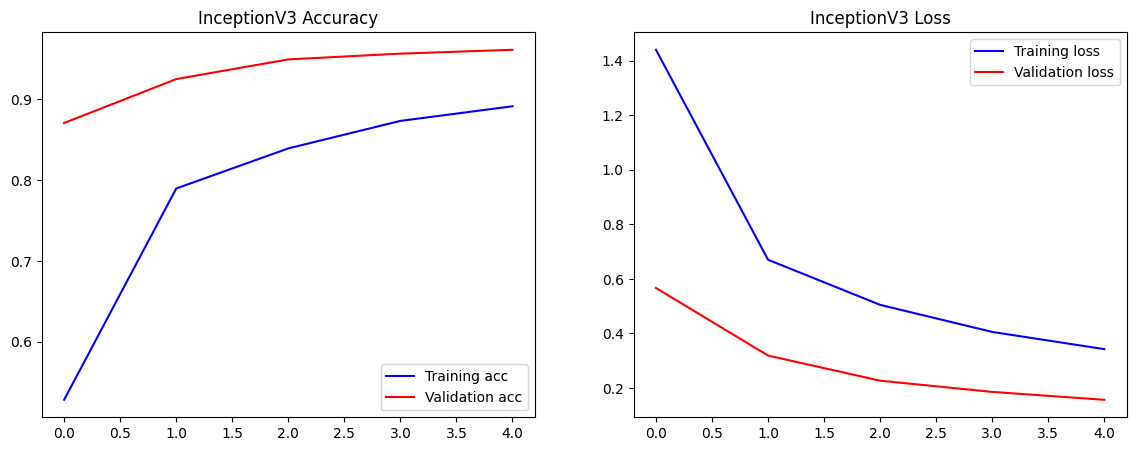

In [11]:
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
inception_model = create_pretrained_model(inception_base, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                          num_classes=num_classes, preprocess_func=inception_preprocess)

inception_model, inception_history, inception_acc = train_and_evaluate_model(inception_model, train_generator, valid_generator, epochs=5, model_name="InceptionV3")
plot_training_history(inception_history, "InceptionV3")

Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 107s 390ms/step - accuracy: 0.1290 - loss: 2.3746 - val_accuracy: 0.1716 - val_loss: 2.3150
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 102s 388ms/step - accuracy: 0.1633 - loss: 2.3319 - val_accuracy: 0.1716 - val_loss: 2.3122
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 102s 388ms/step - accuracy: 0.1598 - loss: 2.3300 - val_accuracy: 0.1716 - val_loss: 2.3110
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 103s 392ms/step - accuracy: 0.1627 - loss: 2.3259 - val_accuracy: 0.1716 - val_loss: 2.3065
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 103s 393ms/step - accuracy: 0.1569 - loss: 2.3273 - val_accuracy: 0.1716 - val_loss: 2.3061
EfficientNetB0 Validation Accuracy: 17.16%


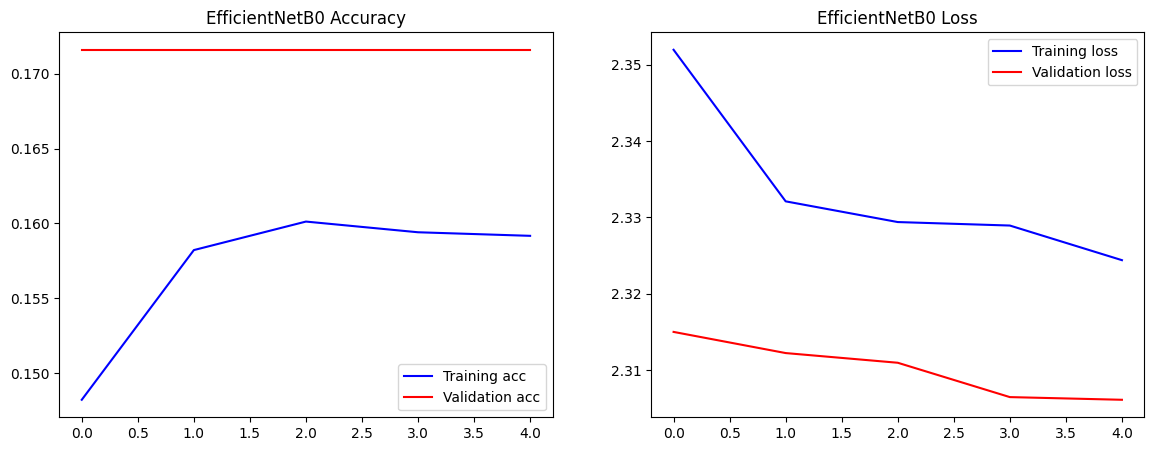

In [12]:
effnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
effnet_model = create_pretrained_model(effnet_base, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                       num_classes=num_classes, preprocess_func=efficientnet_preprocess)

effnet_model, effnet_history, effnet_acc = train_and_evaluate_model(effnet_model, train_generator, valid_generator, epochs=5, model_name="EfficientNetB0")
plot_training_history(effnet_history, "EfficientNetB0")

In [ ]:
model_accuracies = {
    'CNN_Scratch': val_acc,  # from your CNN training
    'VGG16': vgg_acc,
    'ResNet50': resnet_acc,
    'MobileNet': mobile_acc,
    'InceptionV3': inception_acc,
    'EfficientNetB0': effnet_acc
}

# Printing the dictionary
print(model_accuracies)

# Determining best model
best_model_name = max(model_accuracies, key=model_accuracies.get)
print("Best Model:", best_model_name)

{'CNN_Scratch': 0.95853191614151, 'VGG16': 0.7550047636032104, 'ResNet50': 0.18589133024215698, 'MobileNet': 0.9814108610153198, 'InceptionV3': 0.961391806602478, 'EfficientNetB0': 0.17159199714660645}
Best Model: MobileNet


66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step
Confusion Matrix
[[360   0   0   0   0   0   0   0   0   0   0]
 [ 10   0   0   0   0   0   0   0   0   0   0]
 [  0   0 191   0   0   0   0   1   0   2   0]
 [  0   0   0 187   0   0   2   4   0   0   0]
 [  0   0   0   0 188   0   0   0   0   3   0]
 [  0   0   0   0   0 185   0   0   0   7   0]
 [  0   0   0   7   0   0 184   0   0   0   0]
 [  0   0   0   0   0   0   0 191   0   1   0]
 [  0   0   0   0   0   0   0   0 193   0   0]
 [  0   0   0   0   1   0   0   0   1 186   0]
 [  0   0   0   0   0   0   0   0   0   0 194]]
Classification Report
                  precision    recall  f1-score   support

      animalfish       0.97      1.00      0.99       360
  animalfishbass       0.00      0.00      0.00        10
   blackseasprat       1.00      0.98      0.99       194
   giltheadbream       0.96      0.97      0.97       193
  hoursemackerel       0.99      0.98      0.99       191
       redmullet       1.00      0.96      0.98     

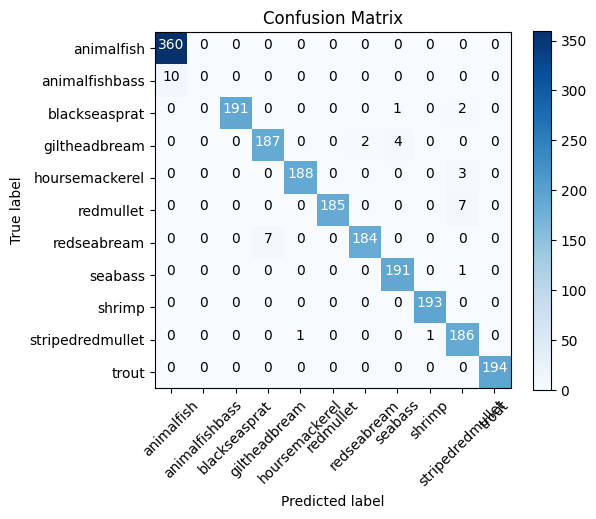

In [ ]:
best_model = mobile_model  
Y_pred = best_model.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
print(cm)

print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

# Visualizing confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm, target_names)

In [ ]:
best_model = mobile_model  
best_model.save('best_model.h5')